In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# Define data directories and parameters
data_dir = r'C:\Users\haris\AI\ML\Projects\Data\Cars Dataset - Copy'
img_size = (224, 224)
batch_size = 32

# Data augmentation settings
datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2]
)

datagen2 = ImageDataGenerator(rescale=1./255, horizontal_flip=False, validation_split=0.2)
datagen3 = ImageDataGenerator(rescale=1./255, horizontal_flip=False)

# Load and split the data
train_images = datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    target_size=img_size,
    class_mode="categorical",
    shuffle=True,
    batch_size=batch_size,
    subset='training'
)

valid_images = datagen2.flow_from_directory(
    os.path.join(data_dir, 'train'),
    target_size=img_size,
    class_mode="categorical",
    shuffle=False,
    batch_size=batch_size,
    subset='validation'
)

test_images = datagen3.flow_from_directory(
    os.path.join(data_dir, 'test'),
    target_size=img_size,
    class_mode="categorical",
    shuffle=False,
    batch_size=batch_size
)

# Load the base model (MobileNetV2)
base_model = MobileNetV2(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.15)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.15)(x)
predictions = Dense(7, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    verbose=1,
    restore_best_weights=True
)


Found 14000 images belonging to 7 classes.
Found 2800 images belonging to 7 classes.
Found 813 images belonging to 7 classes.


In [2]:
# Train the model
history = model.fit(
    train_images,
    validation_data=valid_images,
    batch_size=batch_size,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
438/438 [==============================] - 177s 356ms/step - loss: 0.7822 - accuracy: 0.7308 - val_loss: 0.3827 - val_accuracy: 0.8846
Epoch 2/100
438/438 [==============================] - 130s 298ms/step - loss: 0.4339 - accuracy: 0.8626 - val_loss: 0.4176 - val_accuracy: 0.8679
Epoch 3/100
438/438 [==============================] - 139s 317ms/step - loss: 0.3459 - accuracy: 0.8919 - val_loss: 0.2511 - val_accuracy: 0.9082
Epoch 4/100
438/438 [==============================] - 140s 319ms/step - loss: 0.2855 - accuracy: 0.9113 - val_loss: 0.1867 - val_accuracy: 0.9400
Epoch 5/100
438/438 [==============================] - 142s 324ms/step - loss: 0.2442 - accuracy: 0.9254 - val_loss: 0.1817 - val_accuracy: 0.9346
Epoch 6/100
438/438 [==============================] - 140s 320ms/step - loss: 0.2069 - accuracy: 0.9364 - val_loss: 0.1413 - val_accuracy: 0.9475
Epoch 7/100
438/438 [==============================] - 143s 327ms/step - loss: 0.1972 - accuracy: 0.9411 - val_loss: 0

In [4]:
pip install tensorflow-model-optimization

     -------------------------------------- 241.2/241.2 kB 7.4 MB/s eta 0:00:00
     ---------------------------------------- 15.6/15.6 MB 3.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.3
    Uninstalling numpy-1.22.3:
      Successfully uninstalled numpy-1.22.3
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 1.3.1 requires opencv-python-headless>=4.1.1, which is not installed.
qudida 0.0.4 requires opencv-python-headless>=4.0.1, which is not installed.
tensorboard 2.10.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
tensorflow 2.10.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.


In [6]:
# Pruning configuration
import tensorflow_model_optimization as tfmot
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(
        target_sparsity=0.5,
        begin_step=0,
        end_step=-1,
        frequency=100
    )
}

# Apply pruning to the model
pruned_model = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)

# Create a callback to update pruning at each step
callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

# Compile the pruned model
pruned_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune the pruned model
history_pruned = pruned_model.fit(
    train_images,
    validation_data=valid_images,
    batch_size=batch_size,
    epochs=100,
    callbacks=callbacks  # Include the UpdatePruningStep callback here
)

# Evaluate the pruned model on test data
test_evaluation_pruned = pruned_model.evaluate(test_images)
test_loss_pruned = test_evaluation_pruned[0]
test_accuracy_pruned = test_evaluation_pruned[1]

print(f"Test Loss (Pruned): {test_loss_pruned}")
print(f"Test Accuracy (Pruned): {test_accuracy_pruned}")

# Save the pruned model
pruned_model.save("pruned_car_classification_model.h5")
print("Pruned Model saved successfully.")

# Classification report and confusion matrix
true_classes = test_images.classes
class_names = list(test_images.class_indices.keys())
test_predictions = pruned_model.predict(test_images)
test_predictions_classes = np.argmax(test_predictions, axis=1)
confusion_mat = confusion_matrix(true_classes, test_predictions_classes)
classification_rep = classification_report(true_classes, test_predictions_classes, target_names=class_names)
print("Classification Report:\n", classification_rep)

# Save the pruned model
pruned_model.save("pruned_car_classification_model.h5")
print("Pruned Model saved successfully.")

Epoch 1/100
438/438 [==============================] - 174s 321ms/step - loss: 1.3568 - accuracy: 0.4753 - val_loss: 1.3902 - val_accuracy: 0.4793
Epoch 2/100
438/438 [==============================] - 135s 309ms/step - loss: 1.3260 - accuracy: 0.5204 - val_loss: 1.0113 - val_accuracy: 0.6504
Epoch 3/100
438/438 [==============================] - 141s 323ms/step - loss: 1.0809 - accuracy: 0.6182 - val_loss: 0.8444 - val_accuracy: 0.7157
Epoch 4/100
438/438 [==============================] - 133s 304ms/step - loss: 0.9480 - accuracy: 0.6704 - val_loss: 0.7090 - val_accuracy: 0.7539
Epoch 5/100
438/438 [==============================] - 133s 304ms/step - loss: 0.8430 - accuracy: 0.7124 - val_loss: 0.6712 - val_accuracy: 0.7750
Epoch 6/100
438/438 [==============================] - 135s 309ms/step - loss: 0.7756 - accuracy: 0.7365 - val_loss: 0.5822 - val_accuracy: 0.8104
Epoch 7/100
438/438 [==============================] - 140s 320ms/step - loss: 0.7152 - accuracy: 0.7598 - val_loss: 0

NameError: name 'sn' is not defined

<AxesSubplot:>

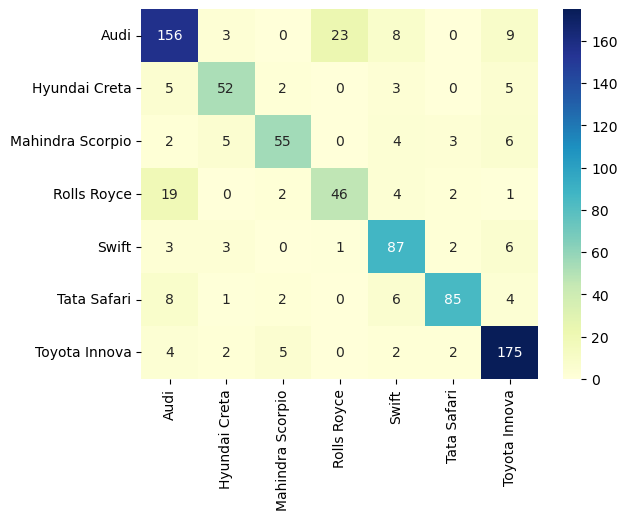

In [7]:
import seaborn as sn
df_cm = pd.DataFrame(confusion_mat, index=class_names, columns=class_names)
sn.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")